In [5]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
start_date = "2023-01-01T12:00:00+08:00"
end_date = "2024-10-31T12:00:00+08:00"
start_date_pd = pd.to_datetime(start_date)
end_date_pd = pd.to_datetime(end_date)

date_range = pd.date_range(start=start_date_pd, end=end_date_pd, freq='D')

url = "https://api.data.gov.sg/v1/environment/rainfall"
weather_df = {}
precipitation_levels=[]
dates = []

for current_date in date_range:
    hourly_prec = []
    for hour in range(10, 20):
        string_version = current_date.strftime(f"%Y-%m-%dT{hour:02d}:00:00+08:00")
        params = {"date_time": string_version}

        response = requests.get(url, params=params)
        curr_data = response.json()
    
        station_id = ''
        # get station id of Sentosa
        for location in curr_data['metadata']['stations']:
            if location['name']=='Sentosa':
                station_id = location['id']
                break

        # get precipitation level
        for location in curr_data['items'][0]['readings']:
            if location['station_id']==station_id:
                hourly_prec.append(location['value'])
                break
    
    precipitation_levels.append(np.mean(hourly_prec) if hourly_prec else 0)
    dates.append(current_date.date())

In [6]:
weather_df = pd.DataFrame({
    'date': dates,
    'precipitation': precipitation_levels
    })
weather_df['date'] = pd.to_datetime(weather_df['date'])
print(weather_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           670 non-null    datetime64[ns]
 1   precipitation  670 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.6 KB
None


(array([621.,  24.,  11.,   6.,   2.,   2.,   1.,   0.,   1.,   2.]),
 array([0.   , 0.124, 0.248, 0.372, 0.496, 0.62 , 0.744, 0.868, 0.992,
        1.116, 1.24 ]),
 <BarContainer object of 10 artists>)

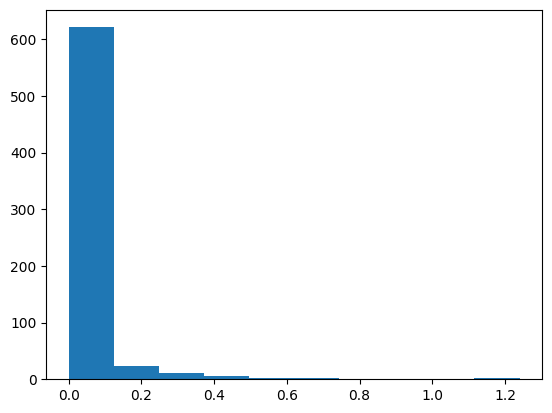

In [7]:
plt.hist(precipitation_levels)

In [8]:
df = pd.DataFrame({'date': date_range.strftime('%Y-%m-%d')})
df['date'] = pd.to_datetime(df['date'])

# fill in missing dates with 0
full_weather_df = df.merge(weather_df, on='date', how='left')
full_weather_df['precipitation'] = full_weather_df['precipitation'].fillna(0)
full_weather_df['date'] = pd.to_datetime(full_weather_df['date'])

In [10]:
# save to csv
full_weather_df.to_csv('sentosa_weather_df.csv', index=False)